# TF-Agents Tutorial

TF-Agents is a Reinforcement Learning framework for designing, implementing and testing new RL algorithms and enables fast code iteration with good test integration and benchmarking.

In [59]:
# Dependencies
import base64
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay
import matplotlib.pyplot as plt

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [29]:
# Gym environment
env_name = 'CartPole-v0'
train_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
eval_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))

In [30]:
# DQN agent
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [31]:
# Policies
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [32]:
def compute_avg_return(environment, policy, num_episodes=10):
    """Compute average return of the policy in the environment over episodes."""
    total_return = 0.0
    for _ in range(num_episodes):
        
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [34]:
# Replay buffer for experience replay
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000)

In [38]:
# Collect trajectories to push into the replay buffer
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

In [39]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

In [42]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, 10)
returns = [avg_return]

for _ in range(20000):
    
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(1):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % 1000 == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, 10)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 8.311055183410645
step = 400: loss = 10.102901458740234
step = 600: loss = 28.950851440429688
step = 800: loss = 29.680843353271484
step = 1000: loss = 17.904109954833984
step = 1000: Average Return = 17.899999618530273
step = 1200: loss = 27.528413772583008
step = 1400: loss = 32.553348541259766
step = 1600: loss = 4.404937744140625
step = 1800: loss = 9.539928436279297
step = 2000: loss = 11.6539306640625
step = 2000: Average Return = 31.5
step = 2200: loss = 42.61044692993164
step = 2400: loss = 10.249664306640625
step = 2600: loss = 59.27980041503906
step = 2800: loss = 63.654541015625
step = 3000: loss = 10.243741035461426
step = 3000: Average Return = 32.20000076293945
step = 3200: loss = 46.973392486572266
step = 3400: loss = 31.427257537841797
step = 3600: loss = 51.883522033691406
step = 3800: loss = 52.59379959106445
step = 4000: loss = 81.546630859375
step = 4000: Average Return = 66.5
step = 4200: loss = 60.314048767089844
step = 4400: loss = 83.368118286

(1.549999999999999, 250)

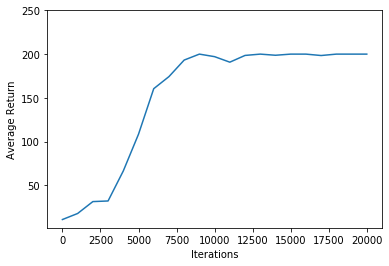

In [48]:
iterations = range(0, 20000 + 1, 1000)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [60]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [61]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [62]:
create_policy_eval_video(random_policy, "random-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
